# Praca Domowa 7 - Wstęp do uczenia maszynowego
## Kinga Ułasik IiAD 02.06.2021

# Potrzebne importy

In [6]:
import logging
from time import time
from sklearn.datasets import load_digits
from numpy.random import RandomState
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, cluster
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.decomposition import PCA

# Wczytanie danych

In [220]:
train_org = pd.read_csv('train.csv')
test_org = pd.read_csv('test.csv')
val_org = pd.read_csv('val.csv')
train_org.head()
#0 - inlier, 1-outlier

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,12.72,1.75,2.28,22.5,84,1.38,1.76,0.48,1.63,3.30,0.88,2.42,488
1,13.23,3.30,2.28,18.5,98,1.80,0.83,0.61,1.87,10.52,0.56,1.51,675
2,12.58,1.29,2.10,20.0,103,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640
3,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510
4,13.84,4.12,2.38,19.5,89,1.80,0.83,0.48,1.56,9.01,0.57,1.64,480


In [221]:
train = train_org.copy()
test = test_org.copy()
val = val_org.copy()

# Gausian Mixture Models - outlier detection

In [65]:
from sklego.mixture import GMMOutlierDetector
mod = GMMOutlierDetector(n_components=16, threshold=0.95).fit(train)
c = mod.predict(train)
c

array([ 1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [117]:
#chcemy zrobić taki model żeby dla train zwracał same jedynki, bo zbiór nie zawieraobserwacji odstających
true = [0]*95

def mapping(array):
    pred=[]
    for x in array:
        if (x==-1):
            pred.append(1)
        else:
            pred.append(0)
    return pred

def difference(true, pred):
    diff = 0;
    for i in range(len(true)):
        if true[i] != pred[i]:
            diff = diff + 1
    return diff

In [224]:
n_components = arange(start=1, stop=17)
threshold =arange(start = 0.8, stop=1,step=0.01)
methods =['quantile','stddev']
min = 100

for mth in methods:
    for component in n_components:
        for thr in threshold:
            mod = GMMOutlierDetector(n_components=component, threshold=thr, method=mth)
            mod.fit(train)
            c = mod.predict(train)
            pred = mapping(c)
            diff = difference(true,pred)
            if diff < min:
                diff_final = diff
                comp_final = component
                thr_final = thr
                mth_final = mth
                min = diff
            
print('Number of wrongly classified observations:', diff_final)
print('Optimal number of components:',comp_final)
print('Optimal threshold:',thr_final)
print('Optimal method:',mth_final)        

Number of wrongly classified observations: 1
Optimal number of components: 1
Optimal threshold: 0.9900000000000002
Optimal method: quantile


# Szybka wizualizacja za pomocą PCA

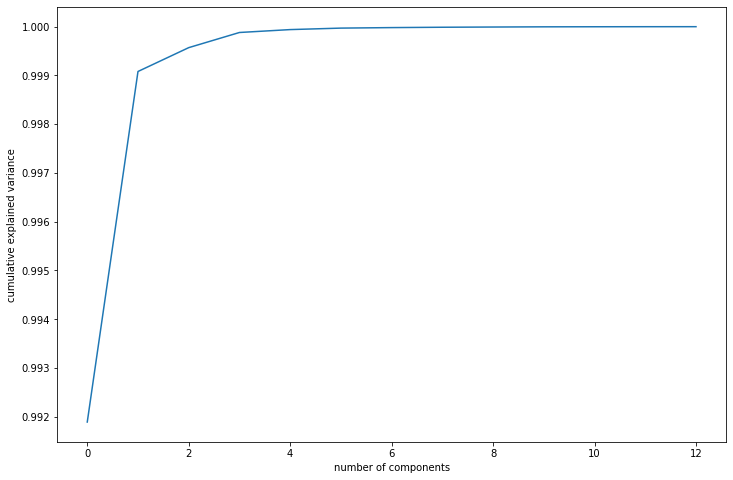

In [148]:
pca = PCA()
pca.fit(train)
#spojrzyjmy na 'wytłumaczalność' wariancji w zależności od ilości komponentów
plt.figure(1, figsize=(12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Zauważmy że 2 komponenty wytłumaczą ponad 99% wariancji, więc możemy spokojnie to zastosować

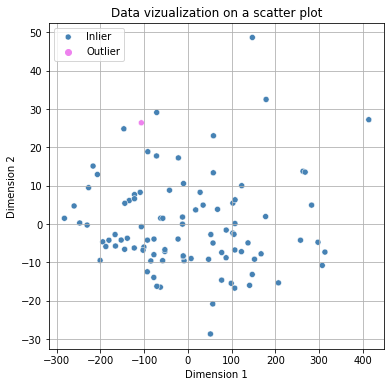

In [184]:
pca = PCA(n_components = 2)
train_pca = pca.fit_transform(train)
train_pca = pd.DataFrame(train_pca, columns=['pca_component_1', 'pca_component_2'])

mod = GMMOutlierDetector(n_components=1, threshold=0.99, method='quantile')
mod.fit(train)
c = mod.predict(train)

plt.figure(figsize =(6, 6))
sns.scatterplot(data = train_pca, x = 'pca_component_1', y = 'pca_component_2', hue=c, palette=['violet', 'steelblue'])
plt.title("Data vizualization on a scatter plot")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(loc='upper left', labels=['Inlier', 'Outlier'])
plt.grid()
plt.show()

Na wykresie została zaznaczona obserwacja odstającą, znajduje się ona w troche nietypowym miejscu, ale możliwe że to kwestia PCA

# Sprawdzanie na zbiorze testowym

In [154]:
from sklearn.metrics import f1_score, precision_score, recall_score
mod = GMMOutlierDetector(n_components = 1, threshold=0.99, method='quantile')
mod.fit(train)

X = test.drop('class',axis=1)

pred_test = mod.predict(X)
pred_test = mapping(pred_test)

#NAJS
print('F1 score:',f1_score(test['class'], pred_test))
print('Precision:',precision_score(test['class'], pred_test))
print('Recall:',recall_score(test['class'], pred_test))
print('Number of missclasified observations:', difference(test['class'], pred_test))

F1 score: 0.9090909090909091
Precision: 0.8333333333333334
Recall: 1.0
Number of missclasified observations: 1


Wartość F1 score jest całkiem wysoka (im bliżej 1 tym model radzi sobie lepiej, im bliżej zera tym gorzej). Precision ma się troche gorzej, tylko ok. 83% wykrytych outlierów faktycznie były outlier'ami, za to recall wynosi 1 - to znaczy, że model wykrył wszystkie istniejące outliery. Czyli, podsumowując, Detector wykrył o jedengo outliera za dużo.

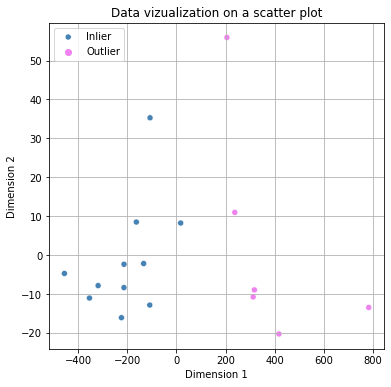

In [193]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca, columns=['pca_component_1', 'pca_component_2'])

mod = GMMOutlierDetector(n_components=1, threshold=0.99, method='quantile')
mod.fit(train)
c = mod.predict(X)

plt.figure(figsize =(6, 6))
sns.scatterplot(data = X_pca, x = 'pca_component_1', y = 'pca_component_2', hue=c, palette=['violet','steelblue'])
plt.title("Data vizualization on a scatter plot")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(loc='upper left', labels=['Inlier', 'Outlier'])
plt.grid()
plt.show()

Instuicyjnie wykryte outliery faktycznie odstają od reszty.

Narysujmy jeszcze wykres jak powinno to wyglądać

In [216]:
#bez tego z jakiegos powodu legenda źle się tworzy
def reverse_mapping(array):
    pred=[]
    for x in array:
        if (x==1):
            pred.append(-1)
        else:
            pred.append(1)
    return pred

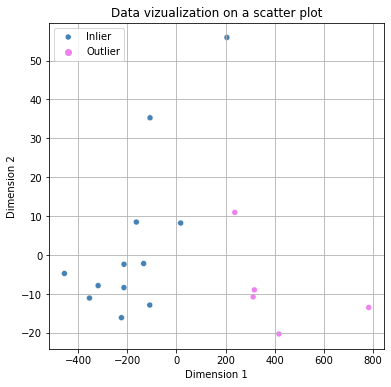

In [215]:
plt.figure(figsize =(6, 6))
sns.scatterplot(data = X_pca, x = 'pca_component_1', y = 'pca_component_2', hue=reverse_mapping(test['class']), palette=['violet','steelblue'])
plt.title("Data vizualization on a scatter plot")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(loc='upper left', labels=['Inlier', 'Outlier'])
plt.grid()
plt.show()

# Sprawdzanie na zbiorze validacyjnym

In [178]:
val.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0.832858,-0.846164,1.373515,1.689058,-0.833329,0.891960,0.648320,-1.315537,0.757469,-0.662656,2.093865,0.674855,-0.880666
1,0.196206,0.920647,0.456893,0.906660,0.951439,-0.693296,-1.231650,0.636887,-0.251629,1.046961,-0.989228,-1.555530,0.370932
2,-0.606529,0.523115,-0.411487,-0.462535,-0.610233,-1.134411,-1.311838,0.370647,-1.216854,2.337896,-0.895800,-1.290671,0.131656
3,-1.229340,-1.170080,-1.376353,-0.853733,-0.610233,1.677695,1.441293,-1.049297,0.932965,-0.174194,0.599032,0.131199,0.039627
4,0.334608,-0.625313,1.084056,-0.266936,0.282151,0.312997,0.425574,-0.694311,0.296794,-0.601598,0.972740,1.594889,0.720643


Jak widać, zbiór walidacyjny nie ma kolumny 'class' więc jesteśmy w stanie okreslić jakoś działania Detectora tylko na podstawie wizualizacji

In [222]:
mod = GMMOutlierDetector(n_components=1, threshold=0.99, method='quantile')
mod.fit(train)
c = mod.predict(val)
c

array([ 1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1])

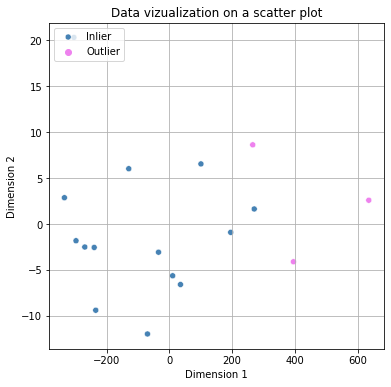

In [223]:
pca = PCA(n_components = 2)
val_pca = pca.fit_transform(val)
val_pca = pd.DataFrame(val_pca, columns=['pca_component_1', 'pca_component_2'])

plt.figure(figsize =(6, 6))
sns.scatterplot(data = val_pca, x = 'pca_component_1', y = 'pca_component_2', hue=c, palette=['violet','steelblue'])
plt.title("Data vizualization on a scatter plot")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(loc='upper left', labels=['Inlier', 'Outlier'])
plt.grid()
plt.show()